YF.download() has changed argument auto_adjust default to True


[                       0%                       ]

[***********           22%                       ]  2 of 9 completed

[***********           22%                       ]  2 of 9 completed

[**********************56%**                     ]  5 of 9 completed

[**********************78%************           ]  7 of 9 completed

[**********************89%******************     ]  8 of 9 completed

[*********************100%***********************]  9 of 9 completed

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

[*********************100%***********************]  1 of 1 completed

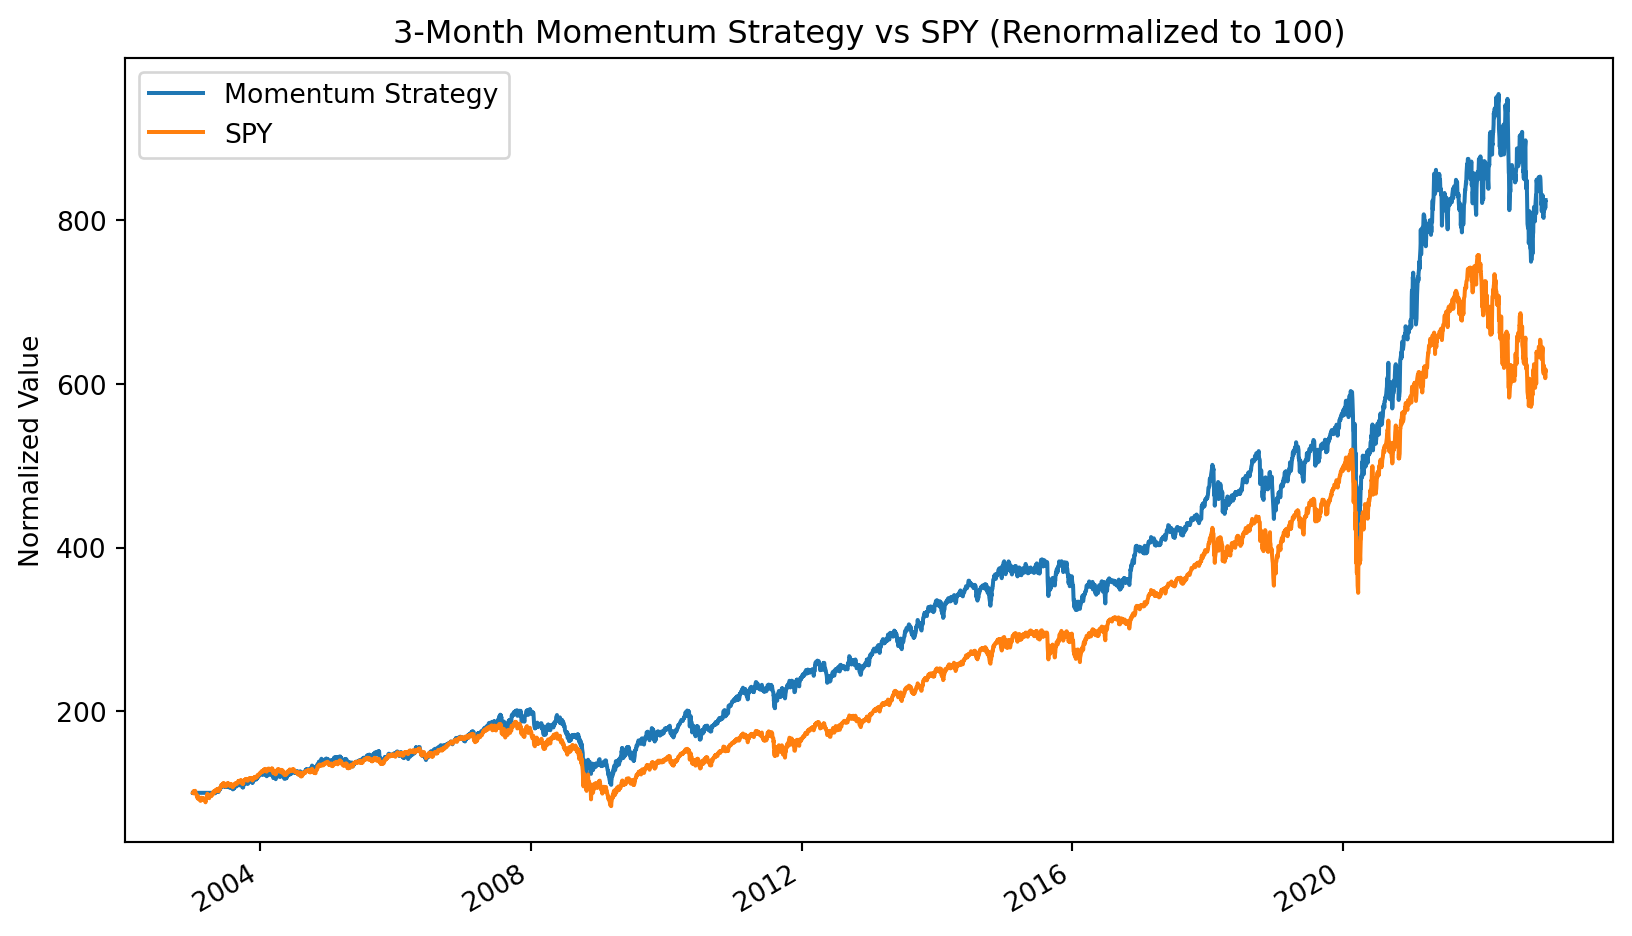

No weights recorded.


In [1]:
# Install required packages (uncomment if needed)
# !pip install bt yfinance matplotlib pandas

import yfinance as yf
import bt
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1. Download 20 Years of Daily Data for Sector ETFs
# ---------------------------
tickers = ["XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY"]
data = yf.download(tickers, start="2003-01-01", end="2023-01-01")["Close"]

# ---------------------------
# 2. Define Custom Algorithms for Momentum Selection, Weighting, and Recording Weights
# ---------------------------
class SelectTopMomentum(bt.Algo):
    """
    Computes momentum based on 3 months (≈63 trading days) of returns with a 1‑week lag,
    then selects the top n securities.
    """
    def __init__(self, lookback=63, n=3, lag=pd.Timedelta(weeks=1)):
        super().__init__()
        self.lookback = lookback
        self.n = n
        self.lag = lag

    def __call__(self, target):
        prices = target.universe
        current_date = target.now
        
        # Determine the observation date with a 1‑week lag
        observation_date = current_date - self.lag
        if observation_date not in prices.index:
            try:
                observation_date = prices.index[prices.index.get_loc(observation_date, method='pad')]
            except Exception:
                return True  # Skip if no valid observation date is found
        
        # Get price window for the lookback period ending at the observation date
        window = prices.loc[:observation_date].tail(self.lookback)
        if len(window) < self.lookback:
            return True  # Not enough data
        
        # Compute momentum as percentage change from the start to the end of the window
        momentum = window.iloc[-1] / window.iloc[0] - 1
        
        # Rank ETFs by momentum (highest first) and select the top n
        sorted_momentum = momentum.sort_values(ascending=False)
        selected = sorted_momentum.index[:self.n].tolist()
        target.temp['selected'] = selected
        return True

class SelectAndWeigh(bt.Algo):
    """
    Assigns equal weights to the selected securities.
    """
    def __call__(self, target):
        selected = target.temp.get('selected', [])
        if selected:
            weights = {sec: 1.0 / len(selected) for sec in selected}
            target.temp['weights'] = weights
            target.security_list = selected
        return True

class RecordWeights(bt.Algo):
    """
    Records the portfolio weights (from target.temp) at each rebalancing date.
    """
    def __init__(self):
        super().__init__()
        self.weights_history = {}
        
    def __call__(self, target):
        # Record the weights currently in target.temp; use .copy() to prevent later modification.
        self.weights_history[target.now] = target.temp.get('weights', {}).copy()
        return True

# Create an instance of RecordWeights to record the weights
record_weights = RecordWeights()

# ---------------------------
# 3. Define the 3-Month Momentum Strategy with a 1-Week Lag
# ---------------------------
# Note: We reorder our algo chain so that RecordWeights runs before Rebalance,
# ensuring that the weights we just set are recorded.
momentum_strategy = bt.Strategy(
    'Sector Momentum 3M',
    [
        bt.algos.RunMonthly(run_on_end_of_period=True),
        SelectTopMomentum(lookback=63, n=3, lag=pd.Timedelta(weeks=1)),
        SelectAndWeigh(),
        record_weights,  # record weights before rebalancing clears target.temp
        bt.algos.Rebalance()
    ]
)

# ---------------------------
# 4. Run the Backtest
# ---------------------------
test = bt.Backtest(momentum_strategy, data)
result = bt.run(test)

# ---------------------------
# 5. Compare the Strategy with SPY (Normalized to 100)
# ---------------------------
spy_data = yf.download("SPY", start="2003-01-01", end="2023-01-01")["Close"]
spy_data = spy_data.reindex(result[0].prices.index).ffill()

momentum_curve = result[0].prices.squeeze()
spy_series = spy_data.squeeze()

df_compare = pd.concat([momentum_curve, spy_series], axis=1).dropna()
df_compare.columns = ['Momentum Strategy', 'SPY']

# Normalize both series so that the first valid value equals 100
df_compare['Momentum Strategy'] = df_compare['Momentum Strategy'] / df_compare['Momentum Strategy'].iloc[0] * 100
df_compare['SPY'] = df_compare['SPY'] / df_compare['SPY'].iloc[0] * 100

ax1 = df_compare.plot(title='3-Month Momentum Strategy vs SPY (Renormalized to 100)', figsize=(10, 6))
ax1.set_ylabel('Normalized Value')
plt.show()

# ---------------------------
# 6. Plot Historical Holdings as a Stacked Area Chart (Normalized to 100%)
# ---------------------------
weights_history = record_weights.weights_history
if not weights_history:
    print("No weights recorded.")
else:
    # Convert the recorded dictionary to a DataFrame
    weights_df = pd.DataFrame.from_dict(weights_history, orient='index')
    weights_df.index = pd.to_datetime(weights_df.index)
    weights_df = weights_df.sort_index()
    weights_df.fillna(0, inplace=True)
    # Convert weights to percentages (each row should sum to 100%)
    weights_df = weights_df * 100

    ax2 = weights_df.plot.area(stacked=True, figsize=(10, 6),
                               title='Historical Holdings of the Momentum Strategy (%)')
    ax2.set_ylabel('Allocation (%)')
    plt.show()


In [2]:
spy_data

Ticker,SPY
2003-01-01,NaN
2003-01-02,60.344677
2003-01-03,60.530212
2003-01-06,61.597042
2003-01-07,61.444664
...,...
2022-12-23,372.400513
2022-12-27,370.931946
2022-12-28,366.322052
2022-12-29,372.915985
